# Analysis and extraction of patch from DarkSkyMocks

## Author: César Arroyo Cárdenas
Affiliation: Instituto de Física, UNAM

In [2]:
reset # reset button just in case.

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n


Nothing done.


In [3]:
%pylab inline

import numpy as np # n-dimensional array library.
from astropy.table import Table, vstack # A class to represent tables of heterogeneous data.
from astropy.io import fits # Access to FITS (Flexible Image Transport System) files.

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.targets import target_bitmask_to_string

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Analyzing the galaxy catalog (`zcat`) files

In this notebook I will analyze the data inside the galaxy catalogues created under the Dark Sky simulations for DESI. For this I will use the file in the path
`/global/project/projectdirs/desi/users/jguy/mocks/darksky-v1.0.1-v2/zcat-0-level1.fits`.

We are going to try to understand what is inside of this file and understand the information we require.

Information for FITS files can be found in: <br>
* [FITS File handling (astropy.io.fits)](http://docs.astropy.org/en/stable/io/fits/): This is an introduction to FITS files usage.
* [File Handling and Convenience Functions](http://docs.astropy.org/en/stable/io/fits/api/files.html): These are usual functions for handling FITS files. They are found in `astropy.io.fits`.
* [HDU Lists](http://docs.astropy.org/en/stable/io/fits/api/hdulists.html): This is an important class defined in `astropy.io.fits.hdu.hdulist`. This class is what is returned when the function `astropy.io.fits.open` is used. Methods within this class can be found in this link.

The HDU List class is a list of HDUs or Header Data Units. As in the first link:
>  An **HDU (Header Data Unit)** is the highest level component of the FITS file structure, consisting of a header and (typically) a data array or table.

Each HDU List consists of HDUs, and HDUs have attributes `.header` and `.data`. Headers are 80 byte "cards" which have each a keyword, a value and a comment. The data part consist of a [Image HDU](http://docs.astropy.org/en/stable/io/fits/api/images.html)-like or [Table HDU](http://docs.astropy.org/en/stable/io/fits/api/tables.html)-like object.

If the HDU is Image-HDU-like then `.data` will return a `numpy.ndarray` and if the HDU is Table-HDU-like the `.data` will return a `numpy.recarray` object with extended properties. Documentation for each class can be found in [numpy.ndarray](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.html) and [numpy.recarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.recarray.html).

In [4]:
# Absolute path of the file to analyze.
galaxy_catalog = '/global/project/projectdirs/desi/users/jguy/mocks/darksky-v1.0.1-v2/zcat-0-level1.fits'

In [5]:
darktable = fits.open(galaxy_catalog) # Open the file.
print(darktable.info()) # Summarize the info of the HDUs in this HDUList.

Filename: /global/project/projectdirs/desi/users/jguy/mocks/darksky-v1.0.1-v2/zcat-0-level1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ZCATALOG      1 BinTableHDU    119   25144758R x 55C   [K, 8A, 10A, E, E, J, J, J, J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, K, K, K, K, K, K, E, 10A, 10A, 10A, J, K, E, E, E, E, E, E, E]   
None


In [6]:
# As we can see in the above output we have two HDUs in our file.
# The primary HDU is empty and the ZCATALOG HDU is a BinTableHDU with 119 cards in the header
# and 25144758R x 55C dimensions in .data. Here R and C stand for Rows and Columns respectively.
print('\nZCATALOG columns:')
print(darktable['ZCATALOG'].data.names) # See the attribute .names for the ZCATALOG HDU.


ZCATALOG columns:
['TARGETID', 'BRICKNAME', 'SPECTYPE', 'Z', 'ZERR', 'ZWARN', 'NUMOBS', 'BRICKID', 'BRICK_OBJID', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SUBPRIORITY', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'HPXPIXEL', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'VDISP', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH']


In [7]:
darktable[0].header # Header for PRIMARY HDU.

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [8]:
darktable[1].header # Header for ZCATALOG HDU.

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  292 / width of table in bytes                        
NAXIS2  =             25144758 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   55 / number of fields in each row                   
TTYPE1  = 'TARGETID'           / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'BRICKNAME'          / label for field   2                            
TFORM2  = '8A      '           / data format of field: ASCII Character          
TTYPE3  = 'SPECTYPE'        

### Extracting a patch from our Galaxy Catalog
One of the objectives is to extract a patch from our entire dataset. First we are going to make a *RA* vs. *DEC* plot to see the range our dataset covers.

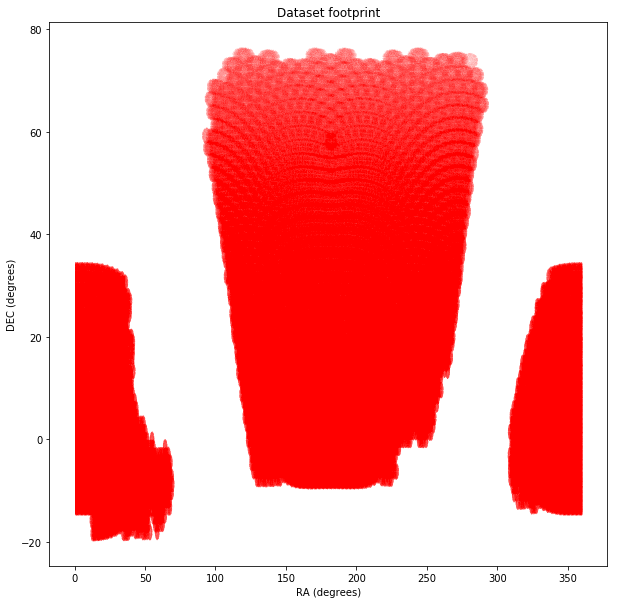

In [9]:
figure(figsize=(10,10))

title('Dataset footprint')
xlabel('RA (degrees)')
ylabel('DEC (degrees)')
plot(darktable[1].data['RA'], darktable[1].data['DEC'], 'r.', markersize=0.01)

We can see from here that our dataset cover a huge area of the sky. In fact it covers approximately one third of the whole sky.

For our purposes we want to extract a patch of this data set for testing some ideas. We are going to work with a patch within $150^° \leq \text{RA} \leq 160^°$ and $40^° \leq \text{RA} \leq 60^°$. The patch we are going to use will be saved in a file called `zcat-0-level1-patch.fits`

In [10]:
hdu_data = darktable[1].data # Point to the ZCATALOG data.

# Create a boolean mask for data which lies inside our defined region.
mask = (hdu_data['RA'] >= 150.) & (hdu_data['RA'] <= 160.) & (hdu_data['DEC'] >= 40.) & (hdu_data['DEC'] <= 60.)
hdu_to_write = hdu_data[mask] # Separate the data with the mask.
hdu = fits.BinTableHDU(data=hdu_to_write, header=darktable[1].header) # Convert data into BinTableHDU object.

# Write FITS file to our DESI user directory.
hdu.writeto('/global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-patch.fits', overwrite=True)

In [11]:
# Close .fits file.
darktable.close()

## Analyzing our patched dataset
We are now going to analyze the characteristics of the patch we have extracted from the full data. We first make a plot of the $\text{RA}$ and $\text{DEC}$ for all of the extracted targets.

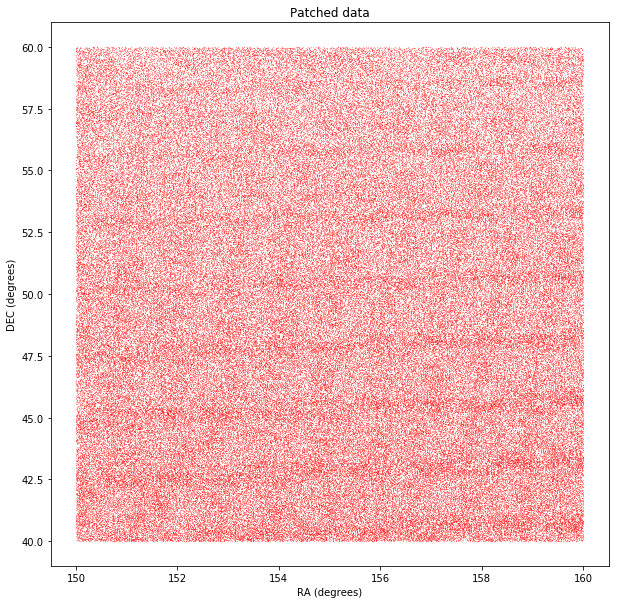

In [113]:
# Absolute path of the file to analyze.
patched_galaxy_catalog = '/global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-patch.fits'
patched_darktable = fits.open(patched_galaxy_catalog)

# We plot all the data points.
figure(figsize = (10,10))
title('Patched data')
xlabel('RA (degrees)')
ylabel('DEC (degrees)')
plot(patched_darktable[1].data['RA'], patched_darktable[1].data['DEC'], 'r.', markersize=0.25)

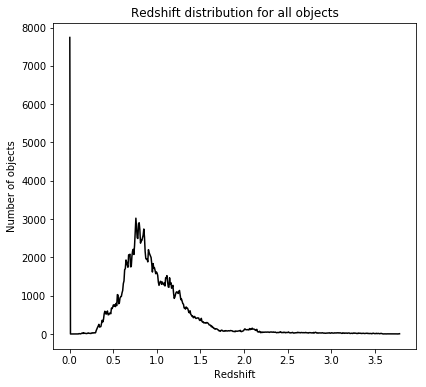

In [116]:
def bin_midpoints(bin_edges):
    ''' Given bin_edges returns bin_midpoints.
    
    Args:
        bin_edges: array_like. The bin edges.
        
    Returns:
        bin_midpoints: The midpoints for the bins.
    '''
    return 0.5*(bin_edges[1:]+ bin_edges[:-1])

# Plotting redshift distribution for all targets.
zall, zall_edges = np.histogram(patched_darktable[1].data['Z'], bins=500)
zall_mids = bin_midpoints(zall_edges)
figure(figsize=(6.5,6))
title('Redshift distribution for all objects')
xlabel('Redshift')
ylabel('Number of objects')
plot(zall_mids, zall, 'k')

In [117]:
print(patched_darktable[1].data.shape)
print()
print(patched_darktable.info()) # Information of the HDU list object.

(219642,)

Filename: /global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-patch.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ZCATALOG      1 BinTableHDU    119   219642R x 55C   ['K', '8A', '10A', 'E', 'E', 'J', 'J', 'J', 'J', 'D', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'E', '10A', '10A', '10A', 'J', 'K', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
None


In [15]:
patched_darktable[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [16]:
patched_darktable[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  292 / length of dimension 1                          
NAXIS2  =               219642 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   55 / number of table fields                         
EXTNAME = 'ZCATALOG'           / name of this binary table extension            
TTYPE1  = 'TARGETID'                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'BRICKNAME'                                                           
TFORM2  = '8A      '        

The most important information from here is that we have 219642 objects. The columns we need are `'RA'`, `DEC` and `'Z'`.<br>
We are now going to see how many objects from which categories we have in our data.

In [118]:
unique_desi, counts_desi = np.unique(patched_darktable[1].data['DESI_TARGET'], return_counts=True)

print(target_bitmask_to_string(unique_desi, desi_mask))
print()
print(counts_desi)

INFO:targets.py:67:target_bitmask_to_string: Target class LRG+LRG_SOUTH (65537): 1
INFO:targets.py:67:target_bitmask_to_string: Target class ELG+ELG_SOUTH (131074): 1
INFO:targets.py:67:target_bitmask_to_string: Target class QSO+QSO_SOUTH (262148): 1
INFO:targets.py:67:target_bitmask_to_string: Target class ELG+QSO+ELG_SOUTH+QSO_SOUTH (393222): 1
INFO:targets.py:67:target_bitmask_to_string: Target class STD_WD (17179869184): 1
INFO:targets.py:67:target_bitmask_to_string: Target class BGS_ANY (1152921504606846976): 1
INFO:targets.py:67:target_bitmask_to_string: Target class MWS_ANY (2305843009213693952): 1
INFO:targets.py:67:target_bitmask_to_string: Target class STD_WD+MWS_ANY (2305843026393563136): 1
['LRG+LRG_SOUTH' 'ELG+ELG_SOUTH' 'QSO+QSO_SOUTH'
 'ELG+QSO+ELG_SOUTH+QSO_SOUTH' 'STD_WD' 'BGS_ANY' 'MWS_ANY'
 'STD_WD+MWS_ANY']

[ 55448 137659  22934      5      2   2813    358    423]


In [119]:
unique_bgs, count_bgs = np.unique(patched_darktable[1].data['BGS_TARGET'], return_counts=True)

print(target_bitmask_to_string(unique_bgs, bgs_mask))
print()
print(count_bgs)

INFO:targets.py:67:target_bitmask_to_string: Target class  (0): 1
INFO:targets.py:67:target_bitmask_to_string: Target class BGS_FAINT+BGS_FAINT_SOUTH (65537): 1
['' 'BGS_FAINT+BGS_FAINT_SOUTH']

[216829   2813]


In [120]:
unique_mws, count_mws = np.unique(patched_darktable[1].data['MWS_TARGET'], return_counts=True)

print(target_bitmask_to_string(unique_mws, mws_mask))
print()
print(count_mws)

INFO:targets.py:67:target_bitmask_to_string: Target class  (0): 1
INFO:targets.py:67:target_bitmask_to_string: Target class MWS_WD (2): 1
INFO:targets.py:67:target_bitmask_to_string: Target class MWS_NEARBY (4): 1
['' 'MWS_WD' 'MWS_NEARBY']

[218861    587    194]


We are going to make a little table which contains how many objects from the different categories do we have.

|Characteristic   | LRG           | ELG  | QSO | BGS_FAINT | MWS_WD | MWS_NEARBY |
|:-----------------:|:---------------:|:-----:|:-----:|:-----:|:-----:|:-----:|
|BitMask          | 65537 | 131074 | 262148 | 65537 | 2 | 4 |
|Number of objects| **55448** | **137659** | **22934** | 2813 | 587 | 194 |

And now we plot only DESI scientific targets.

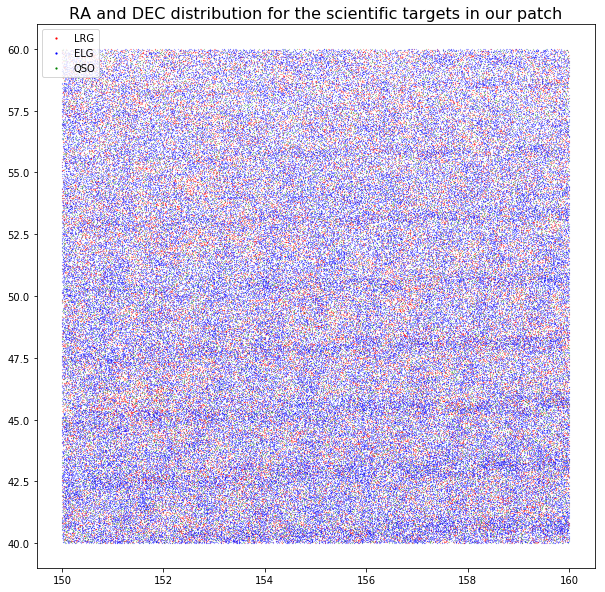

In [121]:
mask_lrg = patched_darktable[1].data['DESI_TARGET'] == 65537
mask_elg = patched_darktable[1].data['DESI_TARGET'] == 131074
mask_qso = patched_darktable[1].data['DESI_TARGET'] == 262148

lrg = patched_darktable[1].data[mask_lrg]
elg = patched_darktable[1].data[mask_elg]
qso = patched_darktable[1].data[mask_qso]

figure(figsize = (10,10))
title('RA and DEC distribution for the scientific targets in our patch', size=16)
plot(lrg['RA'], lrg['DEC'], 'ro', markersize=0.12, label='LRG')
plot(elg['RA'], elg['DEC'], 'bo', markersize=0.12, label='ELG')
plot(qso['RA'], qso['DEC'], 'go', markersize=0.12, label='QSO')

legend(loc='upper left', markerscale=10.)

### Analyzing our data in redshift
Next thing is to understand how `'Z'` is distributed among ELGs. We want to find the probability distribution function. We also want to have in our final catalog objects with valid redshifts. This is, we only need objects with redshifts which will approach the real observation process.

In order to get a sense of 'which redshifts are the valid ones?' we have checked, for every target class, the expected redshift distribution for DESI and the redshift distribution already observed with other surveys. This can be seen in [The DESI Experiment Part I: Science,Targeting, and Survey Design
](https://arxiv.org/abs/1611.00036). In particular check subsection **Sample properties** in sections 3.1, 3.2 and 3.3.

In [122]:
zmin_elg = np.min(elg['Z']); zmax_elg = np.max(elg['Z'])
zmin_lrg = np.min(lrg['Z']); zmax_lrg = np.max(lrg['Z'])
zmin_qso = np.min(qso['Z']); zmax_qso = np.max(qso['Z'])

print("These are z_min and z_max from ELGs, LRGs and QSOs")
print("ELG:", zmin_elg, zmax_elg)
print("LRG:", zmin_lrg, zmax_lrg)
print("QSO:", zmin_qso, zmax_qso)

These are z_min and z_max from ELGs, LRGs and QSOs
ELG: -0.00182047 1.76052
LRG: 0.300005 1.19787
QSO: -0.00163136 3.78681


#### LRGs Redshift Distribution
First we are going to see the redshift distribution for LRGs. For this target class we do not have negative redshifts as seen above. In the DESI design paper we have a preference in the redshift range $0.50 < z < 0.95$. In bins between $0 < z < 0.05$ we have a non zero number of objects. In particular the low-z sample from SDSS/BOSS contains a lot of objects between $0.05 < z < 0.8$. So we do expect several objects with a low redshift.

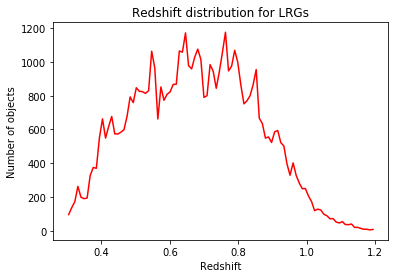

In [126]:
zhist, zedges = np.histogram(lrg['Z'], bins=100, density=False)
zmids = bin_midpoints(zedges)

title('Redshift distribution for LRGs', size=12)
xlabel('Redshift')
ylabel('Number of objects')
plot(zmids, zhist, 'r')

**Conclusion:** The redshift distribution for LRGs seem well behaved. We are going to leave it this way.

#### ELGs Redshift Distribution
For this target class we do have negative redshifts we have to be eliminated for further analysis. The redshift distribution for the DESI's ELGs sample is found in the DESI paper and shows no galaxies outside the range $0.6 < z < 1.7$.

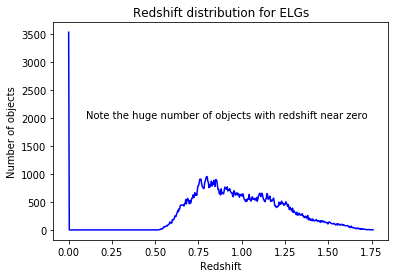

In [127]:
zhist, zedges = np.histogram(elg['Z'], bins=500, density=False)
zmids = bin_midpoints(zedges)

title('Redshift distribution for ELGs', size=12)
text(x=0.1, y=2000., s='Note the huge number of objects with redshift near zero')
xlabel('Redshift')
ylabel('Number of objects')
plot(zmids, zhist, 'b')

The Dark Sky mock actually replicates nicely the expected redshift distribution for ELGs within DESI. However we find a huge number of outliers for our sample that should be removed. Using the histogram counts and the histogram bins we are going to find the redshift from which we should remove the outliers.

In [128]:
print(zhist[0:20], zedges[0:21]) # Histogram with 500 bins.

[3530    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0] [-0.00182047  0.00170422  0.0052289   0.00875359  0.01227828  0.01580297
  0.01932766  0.02285235  0.02637703  0.02990172  0.03342641  0.0369511
  0.04047579  0.04400048  0.04752516  0.05104985  0.05457454  0.05809923
  0.06162392  0.06514861  0.06867329]


In [129]:
# We conservatively chose zcut = 0.005.
zcut_elg = 0.005

print('Outliers for in redshift for ELGs:', np.sum(elg['Z'] < zcut_elg))
print('Fraction of these objects in ELG sample:', np.sum(elg['Z'] < zcut_elg)/len(elg['Z']))

Outliers for in redshift for ELGs: 3530
Fraction of these objects in ELG sample: 0.0256430745538


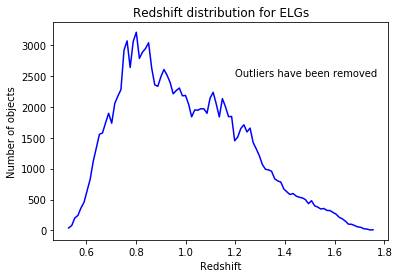

In [130]:
# Removing the objects.
mask_validz = elg['Z'] > 0.005
elg = elg[mask_validz]

# Usual histogram with 100 bins.
zhist, zedges = np.histogram(elg['Z'], bins=100, density=False)
zmids = bin_midpoints(zedges)

title('Redshift distribution for ELGs', size=12)
text(1.2, 2500., 'Outliers have been removed')
xlabel('Redshift')
ylabel('Number of objects')
plot(zmids, zhist, 'b')

**Conclusion:** Objects with redshift $z < 0.005$ need to be removed.

#### QSOs Redshift Distribution
From the DESI survey design paper we have that QSO are going to have a nice distribution in redshift between $0 < z < 4$. In particular we do not expect a lot of objects with redshift close to zero. We expect almost zero objects in redshift bin $0 < z < 0.2$.

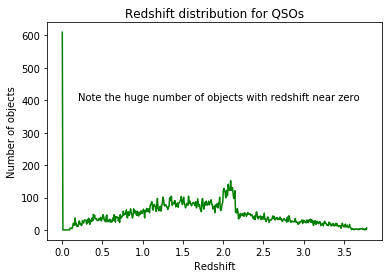

In [131]:
zhist, zedges = np.histogram(qso['Z'], bins=500, density=False)
zmids = bin_midpoints(zedges)

title('Redshift distribution for QSOs', size=12)
text(x=0.2, y=400., s='Note the huge number of objects with redshift near zero')
xlabel('Redshift')
ylabel('Number of objects')
plot(zmids, zhist, 'g')

We have a similar situation as in the ELG sample. We again revise the histogram information in order to find a good redshift to choose as the cut redshift.

In [132]:
print(zhist[0:20], zedges[0:21]) # Histogram with 500 bins.

[610   0   0   0   0   0   0   0   0   0   0   0   0   6   5   5   4  10
  21  19] [-0.00163136  0.00594552  0.0135224   0.02109928  0.02867616  0.03625304
  0.04382992  0.0514068   0.05898368  0.06656056  0.07413744  0.08171432
  0.0892912   0.09686808  0.10444496  0.11202184  0.11959872  0.1271756
  0.13475248  0.14232936  0.14990624]


In [133]:
# We conservatively chose zcut = 0.005.
zcut_qso = 0.005

print('Outliers for in redshift for QSOs:', np.sum(qso['Z'] < zcut_qso))
print('Fraction of these objects in QSO sample:', np.sum(qso['Z'] < zcut_qso)/len(qso['Z']))

Outliers for in redshift for QSOs: 610
Fraction of these objects in QSO sample: 0.0265980640098


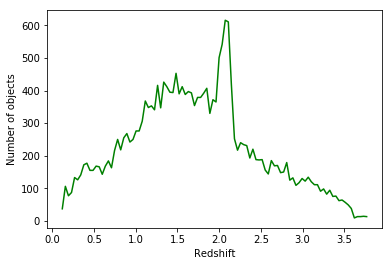

In [134]:
# Removing the objects.
mask_validz = qso['Z'] > 0.005
qso = qso[mask_validz]

# Usual histogram with 100 bins.
zhist, zedges = np.histogram(qso['Z'], bins=100, density=False)
zmids = bin_midpoints(zedges)

xlabel('Redshift')
ylabel('Number of objects')
plot(zmids, zhist, 'g')

**Conclusion:** Objects with redshift $z < 0.005$ need to be removed.

### Cleaning our data in redshift
Now that we know where we have to cut our data we are going to do it in the `patched_darktable` object.
> **Note:** I actually tried to construct a `BinHDUTable` from the separate ELG, LRG and QSO `FITS_Rec` objects but I couldn't do it.

For this we have first to create a mask. We want to retain all objects except from ELGs and QSOs within redshifts $z < 0.005$. This is actually easy to do. We can just create a mask which selects these objects and use the negation to get the desired objects.

In [135]:
nrows = patched_darktable[1].data.shape[0] # Number of rows in our Table.
elg_value = np.full(nrows, fill_value=131074) # Vector containing the BitMask value for ELGs nrows times.
qso_value = np.full(nrows, fill_value=262148) # Same as above for QSOs.
zcut = np.full(nrows, fill_value=0.005) # Vector containing the zcut value nrows times.

# Mask for ELGs and QSOs with z < zcut.
mask_elg = np.logical_and(np.equal(patched_darktable[1].data['DESI_TARGET'], elg_value),
                          np.less(patched_darktable[1].data['Z'], zcut))
mask_qso = np.logical_and(np.equal(patched_darktable[1].data['DESI_TARGET'], qso_value),
                          np.less(patched_darktable[1].data['Z'], zcut))

# Negation of rows containing ELGs and QSOs with z < zcut.
mask = np.logical_not(np.logical_or(mask_elg, mask_qso))

# Update the data.
patched_darktable[1].data = patched_darktable[1].data[mask]

In [136]:
# Write to new FITS file and close HDUList object.
patched_darktable.writeto('/global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-clean-patch.fits',
                          overwrite=True)
patched_darktable.close()

## Constructing clean random file
Now that we have cleared our patch from undesired objects with unvalid redshifts we are going to construct a random file in the same patch in which the ELG sample has the next characteristics:
- $\text{RA}$ and $\text{DEC}$ are uniformly distributed.
- Random ELGs redshifts follow the distribution of the original sample.

In [137]:
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline

In [138]:
# Absolute path of the file to analyze: Patch file cleaned.
patched_galaxy_catalog = '/global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-clean-patch.fits'
# Open the .fits file.
patched_darktable = fits.open(patched_galaxy_catalog)

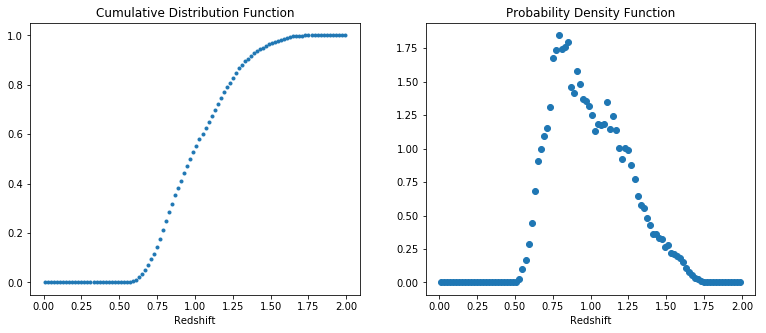

In [151]:
# Substract the ELG data creating a mask.
mask_elg = patched_darktable[1].data['DESI_TARGET'] == 131074
elg = patched_darktable[1].data[mask_elg]

# Compute the redshift probability distribution of ELGs.
# Probability density functon and bins edges.
elg_hist, elg_zbins = np.histogram(a=elg['Z'], bins=100, range=(0.0, 2.0), density=True)
# Midpoints of the bins.
# Array containing the difference between contiguous elements of elg_zmidpoints object.
elg_zmidpoints = bin_midpoints(elg_zbins); elg_diffz = np.diff(elg_zbins)
elghist_length = len(elg_hist) # Length of elg_hist.

# Array to save the ELG redshift CDF.
elg_cdf = np.zeros(elghist_length)

# Fill up the ELG redshift CDF.
for i in np.arange(elghist_length):
    elg_cdf[i] = np.sum(elg_hist[0:i]*elg_diffz[0:i])

# Plot the ELG redshift CDF.
f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(13, 5))

ax0.set(xlabel='Redshift', title='Cumulative Distribution Function')
ax1.set(xlabel='Redshift', title='Probability Density Function')
ax0.plot(elg_zmidpoints, elg_cdf, '.')
ax1.plot(elg_zmidpoints, elg_hist, 'o')
show()

This part provides some utilities that could be useful later. The first one gives the inverse of a function $f$, this is $f^{-1}(x)$ with the restriction we are always looking in the interval $(0,2)$ which coincides with our redshift range. I used the `scipy.interpolate.brentq` method. I am assuming the function is invertible as it's the case for all CDFs by definition.

The second one takes a CDF to construct a set of values following the probability distribution underlying the CDF. The method is the one described in [Inverse transform sampling: The method](https://en.wikipedia.org/wiki/Inverse_transform_sampling#The_method).

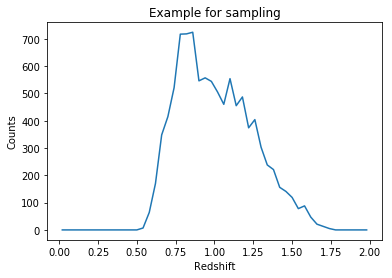

In [155]:
# Interpolate our CDF using the cubic spline method.
interp_cdf = CubicSpline(x=elg_zmidpoints, y=elg_cdf)

def inverse_function(func, a):
    ''' Compute the inverse of the function func at value a.
    
    Args:
        func: Function from which we want to find the inverse.
        a: scalar. Value at which we want to evaluate the inverse.
        
    Returns:
        The inverse of the function func at a.
    '''
    
    # Auxiliar function. To find the inverse of f(x) we must solve f(x) = a.
    g = lambda x : func(x) - a
    x = brentq(g, 0., 2.) # Use brentq method.
    
    return x

# Function is vectorized.
inverse_function = np.vectorize(inverse_function)

def inverse_sampling(cdf, n_values):
    ''' Applies the inverse transform sampling method for a given CDF and
    returns n_values values following the density probability function.
    
    Args:
        cdf: Function. Cumulative distribution function.
        n_values: Integer. Number of values we want to sample from given CDF.
        
    Returns:
        ndarray: Vector containing values following probability distribution given by cdf.
    '''
    
    np.random.seed(50) # Fix the random seed for reproducibility.
    uni_trial = np.random.random(n_values) # Array with uniform random distribution.
    
    return inverse_function(cdf, uni_trial)

# Here is a little test with 10000 numbers.
test = inverse_sampling(interp_cdf, 10000)
hist, edges = np.histogram(test, bins=50, range=(0., 2.))
edges = bin_midpoints(edges)

xlabel('Redshift')
ylabel('Counts')
title('Example for sampling')
plot(edges, hist)

In [156]:
n_elg = len(elg) # Number of ELGs
np.random.seed(1) # Fix random seed for reproducibility

# Minimum an maximum values for RA and DEC.
ramin = 150.; ramax = 160.; decmin = 40.; decmax = 60.;
phimin = np.radians(90.-decmin) # Changes declination to polar angle $\theta$.
phimax = np.radians(90.-decmax)

# Fill RA and DEC uniformly.
ra_random = np.random.uniform(ramin, ramax, n_elg)
dec_random = 90. - np.degrees(np.arccos(np.random.uniform(np.cos(phimin), np.cos(phimax), n_elg)))

# Redshifts from interpolated CDF.
random_redshifts = inverse_sampling(interp_cdf, n_elg)

# Replace with the new values.
for i in np.arange(n_elg):
    if patched_darktable[1].data['DESI_TARGET'][i] == 131074:
        patched_darktable[1].data['Z'][i] = random_redshifts[i]
        patched_darktable[1].data['RA'][i] = ra_random[i]
        patched_darktable[1].data['DEC'][i] = dec_random[i]

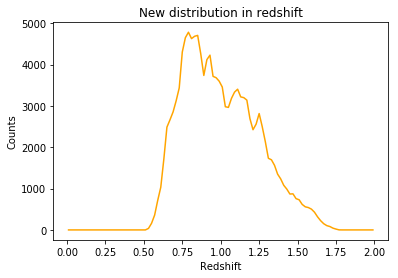

In [160]:
# See the new distribution in redshift.
elg = patched_darktable[1].data[mask_elg]
zhist, zedges = np.histogram(elg['Z'], bins=100, range=(0.,2.))
zmid = bin_midpoints(zedges)

xlabel('Redshift')
ylabel('Counts')
title('New distribution in redshift')
plot(zmid, zhist, 'orange')

In [161]:
data = patched_darktable[1].data
header = patched_darktable[1].header
        
hdu = fits.BinTableHDU(data=data, header=header)
# Write FITS file to our DESI user directory.
hdu.writeto('/global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-random.fits', overwrite=True)

In [162]:
patched_darktable.close()

In [ ]:
random_galaxy_catalog = '/global/project/projectdirs/desi/users/arroyoc/zcat-0-level1-random.fits'
random_darktable = fits.open(random_galaxy_catalog)

mask_lrg = random_darktable[1].data['DESI_TARGET'] == 65537
mask_elg = random_darktable[1].data['DESI_TARGET'] == 131074
mask_qso = random_darktable[1].data['DESI_TARGET'] == 262148

lrg = random_darktable[1].data[mask_lrg]
elg = random_darktable[1].data[mask_elg]
qso = random_darktable[1].data[mask_qso]

figure(figsize = (10,10))
plot(lrg['RA'], lrg['DEC'], 'ro', markersize=0.12, label='LRG')
plot(elg['RA'], elg['DEC'], 'bo', markersize=0.12, label='ELG')
plot(qso['RA'], qso['DEC'], 'go', markersize=0.12, label='QSO')

legend(loc='upper left', markerscale=10.)

random_darktable.close()

In [ ]:
desi_mask

In [ ]:
bgs_mask

In [ ]:
mws_mask

In [ ]:
print(desi_mask.bitnum('ELG'))
print(desi_mask.bitname(9))

In [ ]:
print(type(patched_darktable[1].data['DESI_TARGET'][0:100]))